In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import numpy as np
from pandas.tseries.offsets import DateOffset

from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error

from fbprophet import Prophet

In [5]:
def df_bw_dates(og_df, month, start_day_num, end_day_num, groupby=False):
    
    """
    This takes in the plant gen or wthr dataframe, a number for the month, 
    & a number for the start/end day,
    and returns a dataframe with records between those 2 dates, inclusive.
    
    Groupby is done by DATE_TIME, sum(). Default is False
    """
    
    return_df = og_df[(og_df.index.month == month) & 
                          (og_df.index.day >= start_day_num) &
                          (og_df.index.day <= end_day_num)]
    
    if groupby == True:
        return return_df.groupby('DATE_TIME').sum()
    else:
        return return_df

In [6]:
p1_gen = pd.read_csv('../../data/p1_gen_dtindex.csv', index_col=0, parse_dates=True)
p1_gen.head()

,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
DATE_TIME,,,,,,
2020-05-15,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0
2020-05-15,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0
2020-05-15,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0
2020-05-15,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0
2020-05-15,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0


---

# Prophet FSM (non-log)

5 days starting 6/13

- 4 days train
- 1 day test
- 2 days forecasted forward

## Prepping df for prophet model

In [7]:
# creating 6/13 - 6/17 df ['daily_yield']

pred_6_13 = df_bw_dates(p1_gen, 6, 13, 17, groupby=True)
pred_6_13 = pred_6_13[['DAILY_YIELD']]
pred_6_13

,DAILY_YIELD
DATE_TIME,
2020-06-13 00:00:00,5683.214286
2020-06-13 00:15:00,0.000000
2020-06-13 00:30:00,0.000000
2020-06-13 00:45:00,0.000000
2020-06-13 01:00:00,0.000000
...,...
2020-06-17 22:45:00,129571.000000
2020-06-17 23:00:00,129571.000000
2020-06-17 23:15:00,129571.000000


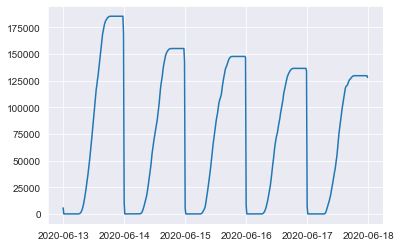

In [8]:
plt.plot(pred_6_13);

In [10]:
# creating a copy of the 6/13 - 6/17 df, for prophet.

prophet_6_13 = pred_6_13.copy()

In [11]:
# need to have two columns for prophet modeling 
# And change their names to ds (datetime) and y (prior datetime data) for prophet
# below transforms the index into a column

prophet_6_13.reset_index(inplace=True)
prophet_6_13

,DATE_TIME,DAILY_YIELD
0,2020-06-13 00:00:00,5683.214286
1,2020-06-13 00:15:00,0.000000
2,2020-06-13 00:30:00,0.000000
3,2020-06-13 00:45:00,0.000000
4,2020-06-13 01:00:00,0.000000
...,...,...
473,2020-06-17 22:45:00,129571.000000
474,2020-06-17 23:00:00,129571.000000
475,2020-06-17 23:15:00,129571.000000
476,2020-06-17 23:30:00,129571.000000


In [12]:
# checking to make sure datetime dtype is preserved

prophet_6_13.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478 entries, 0 to 477
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   DATE_TIME    478 non-null    datetime64[ns]
 1   DAILY_YIELD  478 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 7.6 KB


In [13]:
# re-naming columns:

prophet_6_13.columns = ['ds', 'y']
prophet_6_13

,ds,y
0,2020-06-13 00:00:00,5683.214286
1,2020-06-13 00:15:00,0.000000
2,2020-06-13 00:30:00,0.000000
3,2020-06-13 00:45:00,0.000000
4,2020-06-13 01:00:00,0.000000
...,...,...
473,2020-06-17 22:45:00,129571.000000
474,2020-06-17 23:00:00,129571.000000
475,2020-06-17 23:15:00,129571.000000
476,2020-06-17 23:30:00,129571.000000




## PREDICT- using train/test

In [53]:
eotri = round(prophet_6_13.shape[0] * .8)

train_prophet_6_13 = prophet_6_13[:eotri]
test_prophet_6_13 = prophet_6_13[eotri:]

In [54]:
train_prophet_6_13

,ds,y
0,2020-06-13 00:00:00,5683.214286
1,2020-06-13 00:15:00,0.000000
2,2020-06-13 00:30:00,0.000000
3,2020-06-13 00:45:00,0.000000
4,2020-06-13 01:00:00,0.000000
...,...,...
377,2020-06-16 22:15:00,136429.000000
378,2020-06-16 22:30:00,136429.000000
379,2020-06-16 22:45:00,136429.000000
380,2020-06-16 23:00:00,136429.000000


In [15]:
test_prophet_6_13

,ds,y
382,2020-06-16 23:30:00,136429.000000
383,2020-06-16 23:45:00,134079.375000
384,2020-06-17 00:00:00,6955.232143
385,2020-06-17 00:15:00,0.000000
386,2020-06-17 00:30:00,0.000000
...,...,...
473,2020-06-17 22:45:00,129571.000000
474,2020-06-17 23:00:00,129571.000000
475,2020-06-17 23:15:00,129571.000000
476,2020-06-17 23:30:00,129571.000000


In [43]:
pred_model = Prophet(daily_seasonality=True, weekly_seasonality=False, yearly_seasonality=False)
pred_model.fit(train_prophet_6_13)

In [44]:
# for forecasting: make a DATAFRAME with one column called 'ds'
# containing future dates with time stamps for forecasting forward

pred_future_dates = pd.DataFrame([train_prophet_6_13.ds.iloc[-1] + DateOffset(minutes=x) for x in range(0,1485,15)], 
                           columns=['ds'])[1:]

# 2880 doesn't go all the way to the end of 2 days, bc we're starting earlier
# so use 2910

In [45]:
pred_future_dates

,ds
1,2020-06-16 23:30:00
2,2020-06-16 23:45:00
3,2020-06-17 00:00:00
4,2020-06-17 00:15:00
5,2020-06-17 00:30:00
...,...
94,2020-06-17 22:45:00
95,2020-06-17 23:00:00
96,2020-06-17 23:15:00
97,2020-06-17 23:30:00


In [46]:
pred_forecast = pred_model.predict(pred_future_dates)

In [47]:
pred_forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-06-16 23:30:00,62425.230272,62338.060265,105172.442666,62425.230272,62425.230272,21769.204148,21769.204148,21769.204148,21769.204148,21769.204148,21769.204148,0.0,0.0,0.0,84194.434419
1,2020-06-16 23:45:00,62340.579980,46497.172984,90437.745612,62340.579980,62340.579980,7001.776268,7001.776268,7001.776268,7001.776268,7001.776268,7001.776268,0.0,0.0,0.0,69342.356248
2,2020-06-17 00:00:00,62255.929687,31483.821049,76755.450226,62255.669254,62255.929687,-7941.108917,-7941.108917,-7941.108917,-7941.108917,-7941.108917,-7941.108917,0.0,0.0,0.0,54314.820771
3,2020-06-17 00:15:00,62171.279395,18054.662224,61824.368176,62166.742865,62171.740923,-22624.505236,-22624.505236,-22624.505236,-22624.505236,-22624.505236,-22624.505236,0.0,0.0,0.0,39546.774159
4,2020-06-17 00:30:00,62086.629103,3356.642811,47661.889419,62075.566434,62092.530793,-36625.905390,-36625.905390,-36625.905390,-36625.905390,-36625.905390,-36625.905390,0.0,0.0,0.0,25460.723713
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,2020-06-17 22:45:00,54552.753092,94407.455872,137904.404538,51705.863972,57441.823664,60947.646287,60947.646287,60947.646287,60947.646287,60947.646287,60947.646287,0.0,0.0,0.0,115500.399380
94,2020-06-17 23:00:00,54468.102800,82086.292534,127118.697556,51573.373819,57426.183148,49109.576151,49109.576151,49109.576151,49109.576151,49109.576151,49109.576151,0.0,0.0,0.0,103577.678951
95,2020-06-17 23:15:00,54383.452508,67295.568262,112672.900525,51447.214765,57406.772826,35936.209693,35936.209693,35936.209693,35936.209693,35936.209693,35936.209693,0.0,0.0,0.0,90319.662201
96,2020-06-17 23:30:00,54298.802216,53802.055095,98365.115724,51321.694534,57375.834146,21769.204146,21769.204146,21769.204146,21769.204146,21769.204146,21769.204146,0.0,0.0,0.0,76068.006362


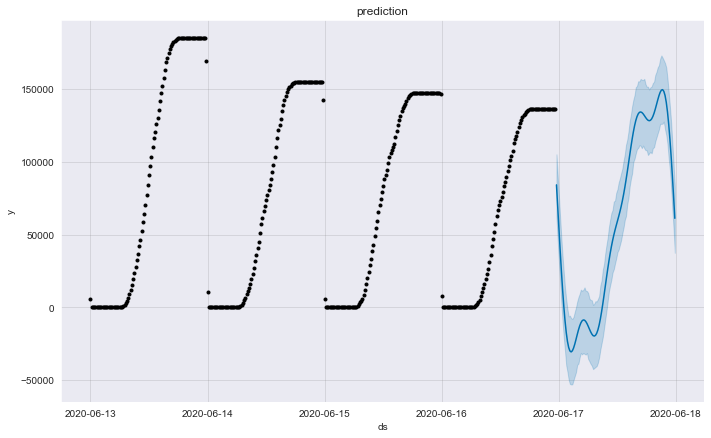

In [125]:
pred_model.plot(pred_forecast)
plt.title('prediction');


## PREDICTION METRICS

In [126]:
pred_metric_df = pred_forecast.set_index('ds')[['yhat']].join(test_prophet_6_13.set_index('ds').y).reset_index()
pred_metric_df

,ds,yhat,y
0,2020-06-16 23:30:00,84194.434419,136429.000000
1,2020-06-16 23:45:00,69342.356248,134079.375000
2,2020-06-17 00:00:00,54314.820771,6955.232143
3,2020-06-17 00:15:00,39546.774159,0.000000
4,2020-06-17 00:30:00,25460.723713,0.000000
...,...,...,...
93,2020-06-17 22:45:00,115500.399380,129571.000000
94,2020-06-17 23:00:00,103577.678951,129571.000000
95,2020-06-17 23:15:00,90319.662201,129571.000000
96,2020-06-17 23:30:00,76068.006362,129571.000000


In [66]:
pred_metric_df.set_index('ds', inplace=True)
print(pred_metric_df.yhat.min())
pred_metric_df

-30617.017617353355


,yhat,y
ds,,
2020-06-16 23:30:00,84194.434419,136429.000000
2020-06-16 23:45:00,69342.356248,134079.375000
2020-06-17 00:00:00,54314.820771,6955.232143
2020-06-17 00:15:00,39546.774159,0.000000
2020-06-17 00:30:00,25460.723713,0.000000
...,...,...
2020-06-17 22:45:00,115500.399380,129571.000000
2020-06-17 23:00:00,103577.678951,129571.000000
2020-06-17 23:15:00,90319.662201,129571.000000


In [67]:
pred_metric_df[pred_metric_df.yhat < 0] = 0
pred_metric_df.yhat.min()

0.0

In [84]:
# NOTE HERE: the calculations below are baed off of negative numbers being zeroed out.
# the graph below, however, isn't- it plots the negative predictions

print('Prophet FSM R2 Score: %f' % (r2_score(pred_metric_df.y, pred_metric_df.yhat)))
print('-'*15)

print('Prophet FSM MAE Score: %f' % (mean_absolute_error(pred_metric_df.y, pred_metric_df.yhat)))
print('-'*15)

print('Prophet FSM RMSE Score: %f' % (mean_squared_error(pred_metric_df.y, pred_metric_df.yhat,squared=False)))

Prophet FSM R2 Score: 0.921673
---------------
Prophet FSM MAE Score: 8480.881520
---------------
Prophet FSM RMSE Score: 16160.541208


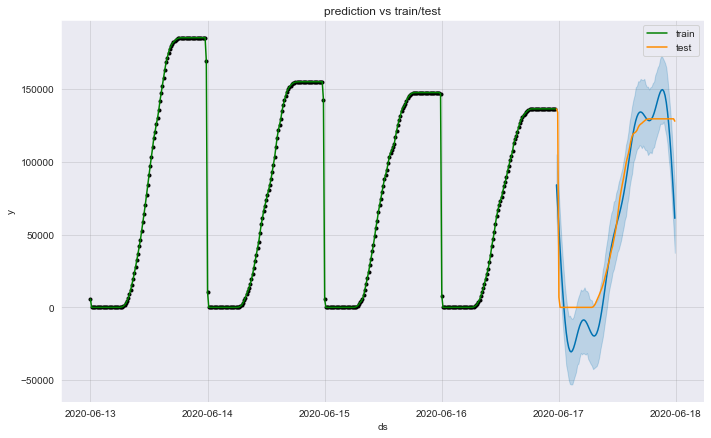

In [89]:
pred_model.plot(pred_forecast)
plt.plot(train_prophet_6_13.ds, train_prophet_6_13.y, label='train', c='g')
plt.plot(test_prophet_6_13.ds, test_prophet_6_13.y, label='test', c='darkorange')
plt.legend()
plt.title('prediction vs train/test')
plt.show()

---

## Prophet Forecast

In [90]:
prophet_6_13

,ds,y
0,2020-06-13 00:00:00,5683.214286
1,2020-06-13 00:15:00,0.000000
2,2020-06-13 00:30:00,0.000000
3,2020-06-13 00:45:00,0.000000
4,2020-06-13 01:00:00,0.000000
...,...,...
473,2020-06-17 22:45:00,129571.000000
474,2020-06-17 23:00:00,129571.000000
475,2020-06-17 23:15:00,129571.000000
476,2020-06-17 23:30:00,129571.000000


In [107]:
forecast_model = Prophet()
forecast_model.fit(prophet_6_13)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


In [102]:
forecast_future_dates = pd.DataFrame([prophet_6_13.ds.iloc[-1] + DateOffset(minutes=x) for x in range(0,2895,15)], 
                           columns=['ds'])[1:]

In [104]:
forecast_future_dates

,ds
1,2020-06-18 00:00:00
2,2020-06-18 00:15:00
3,2020-06-18 00:30:00
4,2020-06-18 00:45:00
5,2020-06-18 01:00:00
...,...
188,2020-06-19 22:45:00
189,2020-06-19 23:00:00
190,2020-06-19 23:15:00
191,2020-06-19 23:30:00


In [119]:
forecast_future = forecast_model.make_future_dataframe(periods=192, include_history=False, freq='15min')
forecast_future

,ds
0,2020-06-18 00:00:00
1,2020-06-18 00:15:00
2,2020-06-18 00:30:00
3,2020-06-18 00:45:00
4,2020-06-18 01:00:00
...,...
187,2020-06-19 22:45:00
188,2020-06-19 23:00:00
189,2020-06-19 23:15:00
190,2020-06-19 23:30:00


In [120]:
forecast_forecast = forecast_model.predict(forecast_future)
forecast_forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-06-18 00:00:00,59521.799860,31373.282172,77883.726789,59521.799860,59521.799860,-5706.876647,-5706.876647,-5706.876647,-5706.876647,-5706.876647,-5706.876647,0.0,0.0,0.0,53814.923213
1,2020-06-18 00:15:00,59455.253744,17907.520538,61259.099193,59455.253744,59455.253744,-20019.228589,-20019.228589,-20019.228589,-20019.228589,-20019.228589,-20019.228589,0.0,0.0,0.0,39436.025155
2,2020-06-18 00:30:00,59388.707629,5080.571065,48441.423181,59388.707629,59388.707629,-33724.635032,-33724.635032,-33724.635032,-33724.635032,-33724.635032,-33724.635032,0.0,0.0,0.0,25664.072597
3,2020-06-18 00:45:00,59322.161514,-10786.146017,35776.000032,59322.161514,59322.161514,-46441.481274,-46441.481274,-46441.481274,-46441.481274,-46441.481274,-46441.481274,0.0,0.0,0.0,12880.680240
4,2020-06-18 01:00:00,59255.615398,-20634.549781,23314.820065,59253.419662,59256.440629,-57838.247636,-57838.247636,-57838.247636,-57838.247636,-57838.247636,-57838.247636,0.0,0.0,0.0,1417.367763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,2020-06-19 22:45:00,47077.676288,84452.322452,132548.309829,41797.993190,52772.670735,60639.154917,60639.154917,60639.154917,60639.154917,60639.154917,60639.154917,0.0,0.0,0.0,107716.831206
188,2020-06-19 23:00:00,47011.130173,72265.510441,119925.983391,41710.051100,52750.624639,49349.982122,49349.982122,49349.982122,49349.982122,49349.982122,49349.982122,0.0,0.0,0.0,96361.112295
189,2020-06-19 23:15:00,46944.584057,59697.719074,107110.803079,41565.712836,52739.503671,36721.837796,36721.837796,36721.837796,36721.837796,36721.837796,36721.837796,0.0,0.0,0.0,83666.421853
190,2020-06-19 23:30:00,46878.037942,47286.061621,95300.706835,41403.445800,52706.148661,23079.581462,23079.581462,23079.581462,23079.581462,23079.581462,23079.581462,0.0,0.0,0.0,69957.619404


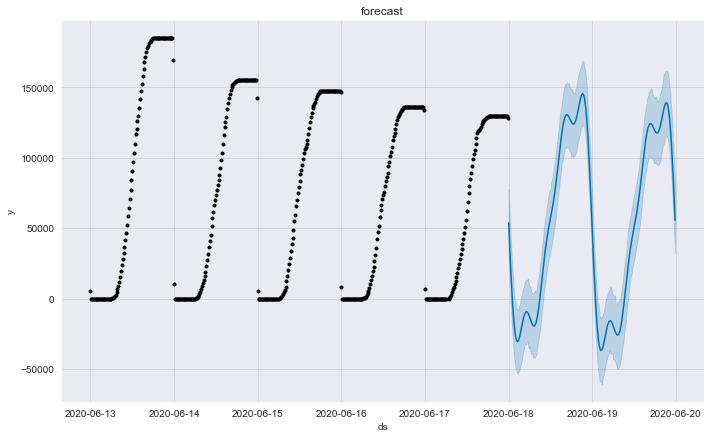

In [124]:
forecast_model.plot(forecast_forecast)
plt.title('forecast');